In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.multioutput import MultiOutputClassifier
import joblib

In [2]:
base_dir = "/Users/fabiancordenod/code/fqbq69/BIMpredict-/raw_data"

dfs = []
for i in range(1, 43):
    murs_path = os.path.join(base_dir, f"maquette{i}", f"murs{i}.csv")
    if os.path.exists(murs_path):
        # Cherche la ligne d'en-tête réelle
        with open(murs_path, encoding="utf-8") as f:
            for idx, line in enumerate(f):
                if line.startswith("Id;"):
                    header_row = idx
                    break
        try:
            df = pd.read_csv(murs_path, sep=';', header=header_row)
            dfs.append(df)
            print(f"Chargé : {murs_path} ({df.shape[0]} lignes, {df.shape[1]} colonnes)")
            print(df.head())
        except Exception as e:
            print(f"Erreur de parsing : {murs_path} -> {e}")
    else:
        print(f"Fichier non trouvé : {murs_path}")

if dfs:
    murs_concat = pd.concat(dfs, ignore_index=True)
    print(f"Total concaténé : {murs_concat.shape[0]} lignes, {murs_concat.shape[1]} colonnes")
else:
    murs_concat = pd.DataFrame()
    print("Aucun fichier murs.csv trouvé.")

murs_concat.head()

Chargé : /Users/fabiancordenod/code/fqbq69/BIMpredict-/raw_data/maquette1/murs1.csv (1589 lignes, 146 colonnes)
       Id 011EC_Lot 012EC_Ouvrage 013EC_Localisation 014EC_Mode Constructif  \
0  779920        GO           MUR          INTERIEUR           POUTRE VOILE   
1  780111        GO           MUR          INTERIEUR           POUTRE VOILE   
2  780661        GO           MUR          INTERIEUR                 BANCHE   
3  783007        GO           MUR          INTERIEUR                 BANCHE   
4  783554        GO           MUR          INTERIEUR           POUTRE VOILE   

           Nom           Hauteur Epaisseur                            AI  \
0  Voile BA 20  2,88000000000138       0,2  -0,0000000000013788124467113   
1  Voile BA 20  2,88000000000138       0,2  -0,0000000000013788124467113   
2  Voile BA 20  2,88000000000138       0,2  -0,0000000000013788124467113   
3  Voile BA 20  2,88000000000138       0,2  -0,0000000000013788124467113   
4  Voile BA 20  2,88000000000138 

,Id,011EC_Lot,012EC_Ouvrage,013EC_Localisation,014EC_Mode Constructif,Nom,Hauteur,Epaisseur,AI,AS,...,Resistance_feu,Materiau_type,Classification.UniFormat.II.Number,Classification.UniFormat.II.Description,CVC_Lot,VOILE SOUS TOITURE,Classe Beton,STR_As NGF,STR_NIV_ref,Prefixe
0,779920,GO,MUR,INTERIEUR,POUTRE VOILE,Voile BA 20,"2,88000000000138","0,2","-0,0000000000013788124467113","2,88",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,780111,GO,MUR,INTERIEUR,POUTRE VOILE,Voile BA 20,"2,88000000000138","0,2","-0,0000000000013788124467113","2,88",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,780661,GO,MUR,INTERIEUR,BANCHE,Voile BA 20,"2,88000000000138","0,2","-0,0000000000013788124467113","2,88",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,783007,GO,MUR,INTERIEUR,BANCHE,Voile BA 20,"2,88000000000138","0,2","-0,0000000000013788124467113","2,88",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,783554,GO,MUR,INTERIEUR,POUTRE VOILE,Voile BA 20,"2,88000000000138","0,2","-0,0000000000013788124467113","2,88",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
murs_concat.shape

(39042, 351)

In [4]:
colonnes_a_garder = [
    "011EC_Lot",
    "012EC_Ouvrage",
    "013EC_Localisation",
    "014EC_Mode Constructif",
    "Epaisseur",
    "Sols en intersection",
    "Sols coupés (u)",
    "Sols coupants (u)",
    "Sol au-dessus",
    "Sol en-dessous",
    "Fenêtres",
    "Portes",
    "Ouvertures",
    "Murs imbriqués",
    "Mur multicouche",
    "Profil modifié",
    "Extension inférieure",
    "Extension supérieure",
    "Partie inférieure attachée",
    "Partie supérieure attachée",
    "Décalage supérieur",
    "Décalage inférieur",
    "Matériau structurel"
]

# On ne garde que les colonnes présentes dans le DataFrame
murs_concat = murs_concat[[col for col in colonnes_a_garder if col in murs_concat.columns]]

In [5]:
import unicodedata
import re

def clean_col(col):
    # Enlever accents
    col = ''.join(c for c in unicodedata.normalize('NFD', col) if unicodedata.category(c) != 'Mn')
    col = col.lower()
    # Remplacer espaces et tirets par _
    col = re.sub(r"[ \-\(\)]", "_", col)
    # Supprimer tout caractère non alphanumérique ou _
    col = re.sub(r"[^a-z0-9_]", "", col)
    # Nettoyer les doubles/triples underscores
    col = re.sub(r"_+", "_", col)
    # Supprimer _ en début/fin
    col = col.strip("_")
    return col

murs_concat.columns = [clean_col(c) for c in murs_concat.columns]
print(murs_concat.columns.tolist())

['011ec_lot', '012ec_ouvrage', '013ec_localisation', '014ec_mode_constructif', 'epaisseur', 'sols_en_intersection', 'sols_coupes_u', 'sols_coupants_u', 'sol_au_dessus', 'sol_en_dessous', 'fenetres', 'portes', 'ouvertures', 'murs_imbriques', 'mur_multicouche', 'profil_modifie', 'extension_inferieure', 'extension_superieure', 'partie_inferieure_attachee', 'partie_superieure_attachee', 'decalage_superieur', 'decalage_inferieur', 'materiau_structurel']


In [ ]:
targets = [
    "011ec_lot",
    "012ec_ouvrage",
    "013ec_localisation",
    "014ec_mode_constructif"
]

# Garder seulement les targets présents dans le DataFrame
targets_in_df = [col for col in targets if col in murs_concat.columns]

if not targets_in_df:
    raise ValueError(f"Aucune colonne cible trouvée dans murs_concat. Colonnes disponibles : {murs_concat.columns.tolist()}")

# X et y_multi
X = murs_concat.drop(columns=targets_in_df)
y_multi = murs_concat[targets_in_df]

if X.shape[1] == 0:
    raise ValueError("Aucune variable explicative disponible après suppression des cibles. Vérifiez vos colonnes.")

num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Pipeline de prétraitement
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), num_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), cat_features)
    ]
)

# Pipeline complet avec MultiOutputClassifier et KNN
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', MultiOutputClassifier(KNeighborsClassifier(n_neighbors=10)))
])

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y_multi, test_size=0.2, random_state=42)

# Supprimer les lignes avec NaN dans les targets (train et test)
train_notna = y_train.notna().all(axis=1)
test_notna = y_test.notna().all(axis=1)
X_train, y_train = X_train[train_notna], y_train[train_notna]
X_test, y_test = X_test[test_notna], y_test[test_notna]

# Entraînement
pipeline.fit(X_train, y_train)


# Sauvegarde du pipeline complet
joblib.dump(pipeline, 'knnmurspipeline.pkl')

print("Pipeline complet sauvegardé dans bimpredict_pipeline.pkl")

Pipeline complet sauvegardé dans bimpredict_pipeline.pkl


In [7]:
print("Accuracy calculée sur", len(y_test), "échantillons.")

Accuracy calculée sur 7117 échantillons.


In [8]:
from sklearn.metrics import f1_score

# Générer les prédictions sur le jeu de test
y_pred = pipeline.predict(X_test)

# Calculer le F1-score pour chaque colonne (target) séparément
f1_micro_list = []
f1_macro_list = []
for i, col in enumerate(y_test.columns):
	f1_micro_list.append(f1_score(y_test.iloc[:, i], y_pred[:, i], average='micro'))
	f1_macro_list.append(f1_score(y_test.iloc[:, i], y_pred[:, i], average='macro'))

# Moyenne des scores F1 sur toutes les cibles
f1_micro_mean = np.mean(f1_micro_list)
f1_macro_mean = np.mean(f1_macro_list)

print(f"F1 micro (moyenne par cible): {f1_micro_mean:.4f}")
print(f"F1 macro (moyenne par cible): {f1_macro_mean:.4f}")

F1 micro (moyenne par cible): 0.9245
F1 macro (moyenne par cible): 0.6116


In [9]:
import pandas as pd
from sklearn.metrics import f1_score

# Calculer le F1-score pour chaque colonne (target) séparément
f1_per_label = []
for i, col in enumerate(y_test.columns):
    f1_per_label.append(f1_score(y_test.iloc[:, i], y_pred[:, i], average='macro'))

# Récupérer les noms de labels
label_names = list(y_test.columns)

# Construire un DataFrame pour lecture facile
f1_report = pd.DataFrame({
    'Label': label_names,
    'F1-score': f1_per_label
})

# Trier du pire au meilleur
f1_report = f1_report.sort_values(by='F1-score')

# Afficher
print(f1_report)

                    Label  F1-score
1           012ec_ouvrage  0.571850
3  014ec_mode_constructif  0.578142
2      013ec_localisation  0.585774
0               011ec_lot  0.710648


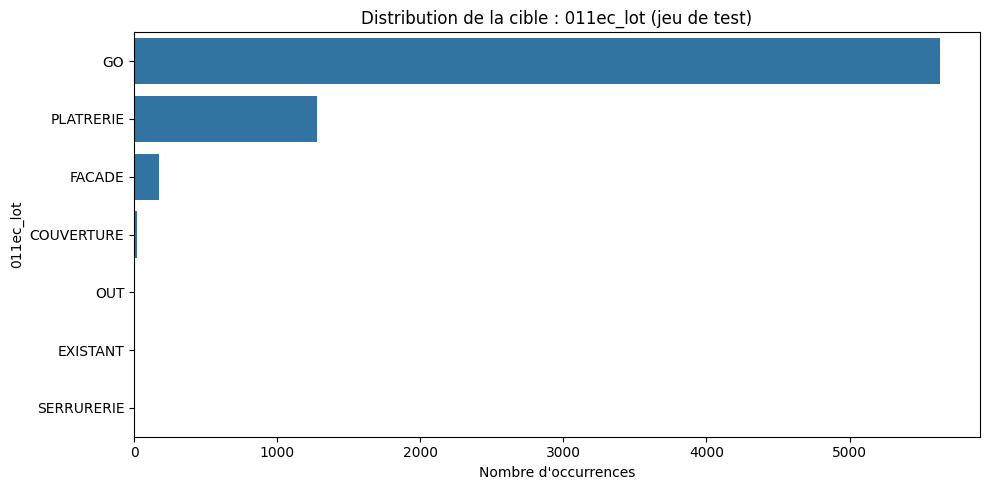

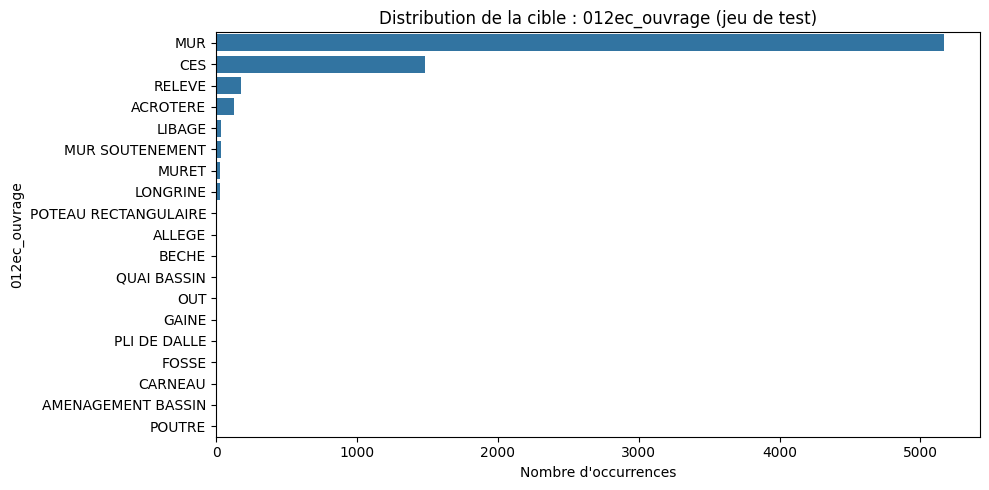

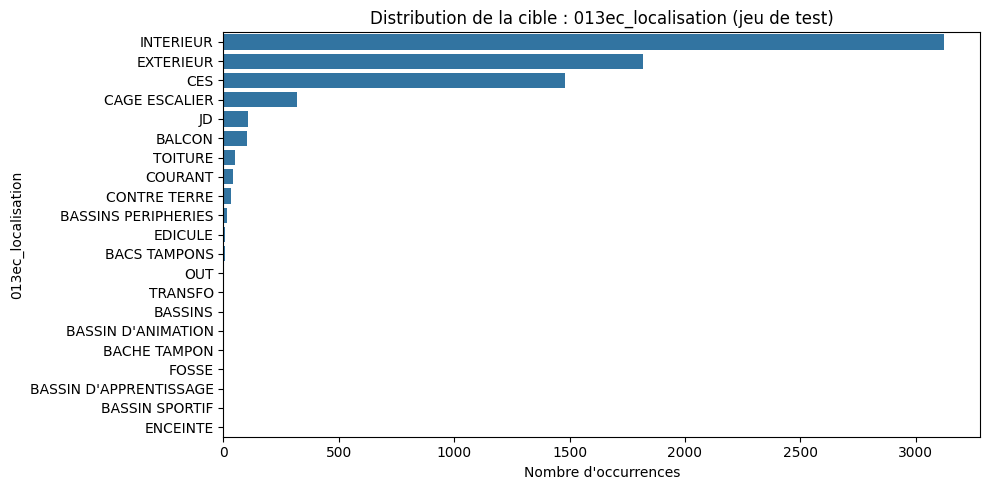

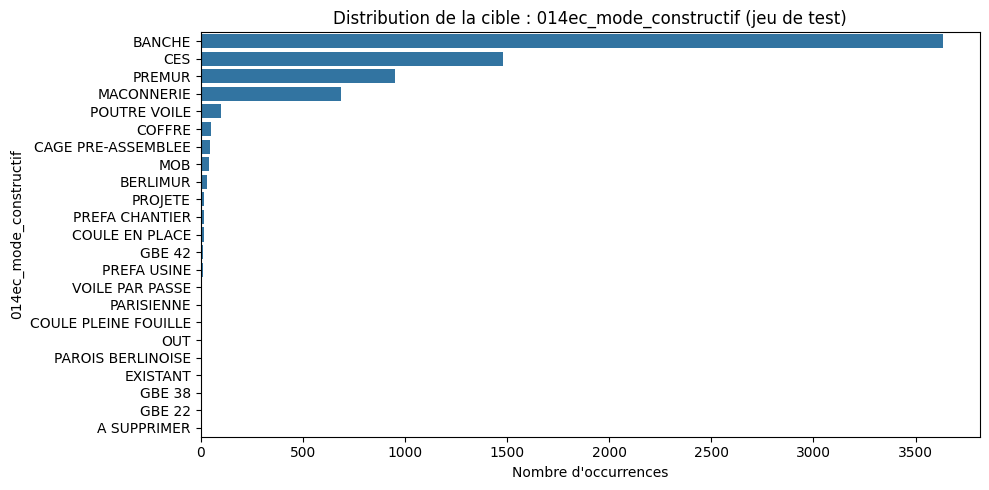

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Afficher la distribution de chaque cible sur y_test
for col in y_test.columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(y=y_test[col], order=y_test[col].value_counts().index)
    plt.title(f"Distribution de la cible : {col} (jeu de test)")
    plt.xlabel("Nombre d'occurrences")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

In [11]:
from sklearn.metrics import classification_report

# Classification report pour chaque cible séparément
for i, col in enumerate(y_test.columns):
	print(f"=== Classification Report for {col} ===")
	print(classification_report(y_test.iloc[:, i], y_pred[:, i]))

=== Classification Report for 011ec_lot ===
              precision    recall  f1-score   support

  COUVERTURE       1.00      1.00      1.00        21
    EXISTANT       0.00      0.00      0.00         3
      FACADE       0.98      0.98      0.98       175
          GO       1.00      1.00      1.00      5630
         OUT       1.00      1.00      1.00         4
   PLATRERIE       1.00      1.00      1.00      1281
  SERRURERIE       0.00      0.00      0.00         3

    accuracy                           1.00      7117
   macro avg       0.71      0.71      0.71      7117
weighted avg       1.00      1.00      1.00      7117

=== Classification Report for 012ec_ouvrage ===
                      precision    recall  f1-score   support

            ACROTERE       0.62      0.74      0.68       131
              ALLEGE       0.86      0.86      0.86         7
  AMENAGEMENT BASSIN       0.00      0.00      0.00         1
               BECHE       0.00      0.00      0.00         4


/Users/fabiancordenod/.pyenv/versions/3.10.6/envs/BIMpredict2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fabiancordenod/.pyenv/versions/3.10.6/envs/BIMpredict2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fabiancordenod/.pyenv/versions/3.10.6/envs/BIMpredict2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

                        precision    recall  f1-score   support

          BACHE TAMPON       0.00      0.00      0.00         2
          BACS TAMPONS       0.75      0.60      0.67         5
                BALCON       0.86      0.88      0.87       101
    BASSIN D'ANIMATION       0.50      1.00      0.67         3
BASSIN D'APPRENTISSAGE       0.50      0.50      0.50         2
        BASSIN SPORTIF       1.00      0.50      0.67         2
               BASSINS       0.00      0.00      0.00         3
   BASSINS PERIPHERIES       0.79      0.79      0.79        14
         CAGE ESCALIER       0.79      0.78      0.79       319
                   CES       1.00      1.00      1.00      1480
          CONTRE TERRE       0.68      0.48      0.57        31
               COURANT       0.90      0.93      0.91        40
               EDICULE       1.00      1.00      1.00         7
              ENCEINTE       0.00      0.00      0.00         1
             EXTERIEUR       0.78      

/Users/fabiancordenod/.pyenv/versions/3.10.6/envs/BIMpredict2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fabiancordenod/.pyenv/versions/3.10.6/envs/BIMpredict2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fabiancordenod/.pyenv/versions/3.10.6/envs/BIMpredict2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa